### In this project,  an artificial agent is trained to solve the Maze task using DQN algorithm

Pytorch is used to build the DQN.

Reference to Pytorch: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

Reference to how to create Torch environment: https://dziganto.github.io/data%20science/python/anaconda/Creating-Conda-Environments/ 

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

In [1]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

In [2]:
RUN_TASK0 = True
RUN_TASK1 = True
RUN_TASK2 = True
RUN_TASK3 = True
RUN_TASK4 = True
RUN_TASK5 = True
RUN_TASK6 = True

In [3]:
alpha = 1e-6
gamma = 0.9
learning_rate = 1e-4
exploration_rate = -1 # -1 means epsilon will be determined according to the epsilon[] list

device = 'mps'
batch_size = 24

**note: change all 'cpu' to 'cuda' if you are using google collab**

**Introduce experience replay.**

In [4]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'mps'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        return torch.Tensor(np.array(states)).type(torch.float).to(device), \
               torch.Tensor(np.array(actions)).type(torch.long).to(device), \
               torch.Tensor(np.array(next_states)).to(device), \
               torch.Tensor(np.array(rewards)).to(device), torch.tensor(np.array(isgameon)).to(device)

**Networks definition.**

In [5]:
class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No = 4): 
        # Ni : number of neurons in input layer
        # Nh1 : number of neurons in hidden layer 1
        # Nh2 : number of neurons in hidden layer 2
        # No : number of neurons in output layer (=4 because there are 4 actions)
        super().__init__()
        
        self.fc1 = nn.Linear(Ni, Nh1) # fc stands for fully connected
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)#No =4 becuase actions are 4 
        
        self.act = nn.ReLU() # activation function (step function, sigmoid, ReLU, etc)
        self.weights=0
        
    def forward(self, x, classification = False, additional_out=False):
        # x is the input
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)
        
        return out
    
# while passing an input x to our nn, we can't just write :
# net = fc_nn(...)
# output = net(x)
# we need to "flatten" the input first :
# x = x.view(Ni,-1)
# output = net(x)

In [6]:
def Qloss(batch, net, gamma=0.99, device="cpu"):
    states, actions, next_states, rewards, _ = batch
    
    #print(actions)
    
    lbatch = len(states)
    state_action_values = net(states.view(lbatch,-1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)
    
    next_state_values = net(next_states.view(lbatch, -1))
    next_state_values = next_state_values.max(1)[0]
    
    next_state_values = next_state_values.detach()
    #print("next_state_values", next_state_values)
    #update the target (see lecture slides)
    target = rewards + gamma * next_state_values #'complete code'
    #print("Target", target)
    return nn.MSELoss()(state_action_values, target)#finding loss between x and y  #'complete code'

**Importing the maze and define the environment.**

In [7]:
class MazeEnvironment:    
    def __init__(self, maze, init_position, goal):
        x = len(maze)
        y = len(maze)
        
        self.boundary = np.asarray([x, y])
        self.init_position = init_position
        self.current_position = np.asarray(init_position)
        self.goal = goal
        self.maze = maze
        
        self.visited = set()
        self.visited.add(tuple(self.current_position))
                
        # initialize the empty cells and the euclidean distance from
        # the goal (removing the goal cell itself)
        self.allowed_states = np.asarray(np.where(self.maze == 0)).T.tolist()
        self.distances = np.sqrt(np.sum((np.array(self.allowed_states) -
                                         np.asarray(self.goal))**2,
                                         axis = 1))
        
        del(self.allowed_states[np.where(self.distances == 0)[0][0]])
        self.distances = np.delete(self.distances, np.where(self.distances == 0)[0][0])
                
        self.action_map = {0: [0, 1],
                           1: [0, -1],
                           2: [1, 0],
                           3: [-1, 0]}
        
        self.directions = {0: '→',
                           1: '←',
                           2: '↓ ',
                           3: '↑'}
        
        # the agent makes an action from the following:
        # 1 -> right, 2 -> left
        # 3 -> down, 4 -> up
        
    # introduce a reset policy, so that for high epsilon the initial
    # position is nearer to the goal (useful for large mazes)
    def reset_policy(self, eps, reg = 7):
        return sp.softmax(-self.distances/(reg*(1-eps**(2/reg)))**(reg/2)).squeeze()
    
    # reset the environment when the game is completed
    # with probability prand the reset is random, otherwise
    # the reset policy at the given epsilon is used
    def reset(self, epsilon, prand = 0):
        if np.random.rand() < prand:
            idx = np.random.choice(len(self.allowed_states))
        else:
            p = self.reset_policy(epsilon)
            idx = np.random.choice(len(self.allowed_states), p = p)

        self.current_position = np.asarray(self.allowed_states[idx])
        
        self.visited = set()
        self.visited.add(tuple(self.current_position))

        return self.state()
    
    
    def state_update(self, action):
        isgameon = True
        
        # each move costs -0.05
        reward = -0.05
        
        move = self.action_map[action]
        next_position = self.current_position + np.asarray(move)
        
        # if the goals has been reached, the reward is 1
        if (self.current_position == self.goal).all():
                reward = 1
                isgameon = False
                return [self.state(), reward, isgameon]
            
        # if the cell has been visited before, the reward is -0.2
        else:
            if tuple(self.current_position) in self.visited:
                reward = -0.2
        
        # if the moves goes out of the maze or to a wall, the
        # reward is -1
        if self.is_state_valid(next_position):
            self.current_position = next_position
        else:
            reward = -1
        
        self.visited.add(tuple(self.current_position))
        return [self.state(), reward, isgameon]

    # return the state to be feeded to the network
    def state(self):
        state = copy.deepcopy(self.maze)
        state[tuple(self.current_position)] = 2
        return state
        
    
    def check_boundaries(self, position):
        out = len([num for num in position if num < 0])
        out += len([num for num in (self.boundary - np.asarray(position)) if num <= 0])
        return out > 0
    
    
    def check_walls(self, position):
        return self.maze[tuple(position)] == 1
    
    
    def is_state_valid(self, next_position):
        if self.check_boundaries(next_position):
            return False
        elif self.check_walls(next_position):
            return False
        return True
    
    
    def draw(self, filename):
        plt.figure()
        im = plt.imshow(self.maze, interpolation='none', aspect='equal', cmap='Greys');
        ax = plt.gca();

        plt.xticks([], [])
        plt.yticks([], [])

        ax.plot(self.goal[1], self.goal[0],
                'bs', markersize = 4)
        ax.plot(self.current_position[1], self.current_position[0],
                'rs', markersize = 4)
        plt.savefig(filename, dpi = 300, bbox_inches = 'tight')
        plt.show()


In [8]:
def build_maze(maze_file):
        '''
        para1: filename of the maze txt file
        return mazes as a numpy array walls: 0 - no wall, 1 - horizontal wall no the bottom of the cell, 2 - vertical wall on the right of the cell
        '''
        a = open(maze_file, 'r')
        m=[]
        for i in a.readlines():
            m.append(np.array(i.split(" "), dtype="int32"))
        return np.array(m)
#maze=build_maze("my_maze_25x25.txt")
#maze=build_maze("maze20x20.txt")
maze=build_maze("my_maze_10x10.txt")


initial_position = [1,1]
goal = [len(maze)-2, len(maze)-2]

maze_env = MazeEnvironment(maze, initial_position, goal)


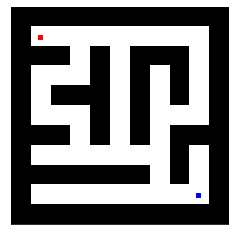

In [9]:
maze_env.draw('maze_20.png')

**Define the agent and the buffer for experience replay.**

In [10]:
buffer_capacity = 10000
buffer_start_size = 1000
memory_buffer = ExperienceReplay(buffer_capacity)

In [11]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])


class Agent:
    def __init__(self, maze, memory_buffer, use_softmax = True):
        self.env = maze
        self.buffer = memory_buffer # this is actually a reference
        self.num_act = 4
        self.use_softmax = use_softmax
        self.total_reward = 0
        self.min_reward = -self.env.maze.size
        self.isgameon = True
        self.rwd = 0

        
    def make_a_move(self, net, epsilon, device = 'mps'):
        #print('inside make_a_move')
        #input()
        action = self.select_action(net, epsilon, device)
        current_state = self.env.state()
        next_state, reward, self.isgameon = self.env.state_update(action)
        self.total_reward += reward
        self.rwd = reward
        #print('action: ', action)
        #print('current state: ', current_state)
        #print('next state: ', next_state)
        #print('reward: ', reward)
        #input()
        
        
        if self.total_reward < self.min_reward:
            self.isgameon = False
        if not self.isgameon:
            self.total_reward = 0
        
        transition = Transition(current_state, action,
                                next_state, reward,
                                self.isgameon)
        
        self.buffer.push(transition)
            
        
    def select_action(self, net, epsilon, device = 'mps'):
        #print('inside select_action')
        #input()
        state = torch.Tensor(self.env.state()).to(device).view(1,-1)
        qvalues = net(state).cpu().detach().numpy().squeeze()
        #print('qvalues:')
        #print(qvalues)
        #input()

        # softmax sampling of the qvalues
        if self.use_softmax:
            p = sp.softmax(qvalues/epsilon).squeeze()
            p /= np.sum(p)
            action = np.random.choice(self.num_act, p = p)
            
        # else choose the best action with probability 1-epsilon
        # and with probability epsilon choose at random
        else:
            if random.uniform(0, 1) < epsilon:  #'complete code'
                action = np.random.randint(self.num_act, size=1)[0] #select a random action A 
            else:                
                action = np.argmax(qvalues, axis=0)#Select an action that has a maximum Q value #'complete code'
                action = int(action)
                
        # add transition noise (alpha) to the system
        action_list = [action] # intended action
        probs = [1 - alpha] # probability of taking the intended action
        for a in range(4):
            if a != action:
                action_list.append(a) # unintended action
                probs.append(alpha) # probability of taking this unintended action

        action_taken = random.choices(action_list, cum_weights=probs)[0]
        
        return action_taken
    
    
    def plot_policy_map(self, net, offset):
        net.eval()
        with torch.no_grad():
            fig, ax = plt.subplots()
            #ax.imshow(self.env.maze, 'Greys')
            q=np.zeros((len(maze), len(maze)), dtype="float64")

            for free_cell in self.env.allowed_states:
                self.env.current_position = np.asarray(free_cell)
                '''
                view is similar to numpy's reshape
                "view" shares the underlying data with the original tensor, so it is really
                a view into the old tensor instead of creating a brand new one
                '''
                #print('checkpoint')
                #print('self.env.state() : ', self.env.state())
                #print('view : ', torch.Tensor(self.env.state()).to('mps').view(1,-1))
                #input()
                #use view(1,-1) for env.state()
                qvalues = net(torch.Tensor(self.env.state()).to('mps').view(1,-1)).detach().squeeze() #'complete code'
                #print('qvalues :', qvalues)
                #input()
                #finding the argmax of qvalues
                action = torch.argmax(qvalues, dim=0).item() #'complete code'
                #print('action : ', action)
                #input()
                #finding the policy from the action
                policy = self.env.directions[action]
                #print('policy : ', policy)
                #input()
                #updating with max qvalue 
                q[free_cell[0],free_cell[1]]= torch.max(qvalues) #'complete code'
                #print('max q :', torch.max(qvalues))
                #input()
                

                ax.text(free_cell[1]-offset[0], free_cell[0]-offset[1], policy)
            #print(q)
            ax.imshow(q)    
            ax = plt.gca();

            plt.xticks([], [])
            plt.yticks([], [])

            #ax.plot(self.env.goal[1], self.env.goal[0], 'bs', markersize = 4)
            plt.show()
            
agent = Agent(maze = maze_env, memory_buffer = memory_buffer, use_softmax = True)

**Define the network. **

In [12]:
net = fc_nn(maze.size, maze.size, maze.size, 4)
target = fc_nn(maze.size, maze.size, maze.size, 4)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net.to(device)

fc_nn(
  (fc1): Linear(in_features=121, out_features=121, bias=True)
  (fc2): Linear(in_features=121, out_features=121, bias=True)
  (fc3): Linear(in_features=121, out_features=4, bias=True)
  (act): ReLU()
)

**Define the epsilon profile and plot the resetting probability.**

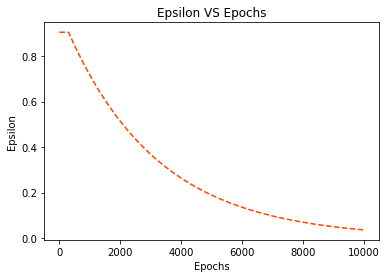

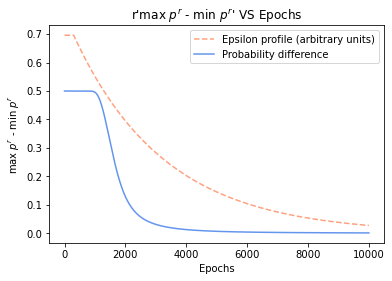

In [13]:
num_epochs = 10000

cutoff = 3000
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
epsilon[epsilon > epsilon[100*int(num_epochs/cutoff)]] = epsilon[100*int(num_epochs/cutoff)]
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.title("Epsilon VS Epochs")
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
#plt.savefig('epsilon_profile.png', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.title("r'max $p^r$ - min $p^r$' VS Epochs")
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
#plt.savefig('reset_policy.png', dpi = 300, bbox_inches = 'tight')
plt.show()

**Training the network.**

In [14]:
# define training as a function
def train(agent, net, target, optimizer, taskname, gamma, exploration_rate=-1):
    
    r_list = []
    loss_log = []
    best_loss = 1e5

    running_loss = 0

    for epoch in range(num_epochs):
        #print("start of training")
        #input()
        
        r_sum = 0

        loss = 0
        counter = 0
        
        if exploration_rate == -1:
            eps = epsilon[epoch]
        else:
            eps = exploration_rate

        agent.isgameon = True
        _ = agent.env.reset(eps)

        #print("checkpoint 1")
        #input()


        while agent.isgameon:

            #print("checkpoint 2")
            #print(net)
            #input()

            agent.make_a_move(net, eps)
            counter += 1
            r_sum += agent.rwd
            #print('r_sum:', r_sum)
            #input()

            #print("checkpoint 3")
            #input()

            if len(agent.buffer) < buffer_start_size:
                continue

            optimizer.zero_grad()
            batch = agent.buffer.sample(batch_size, device = device)
            #print("before Q loss")
            #input()
            loss_t = Qloss(batch, net, gamma = gamma, device = device)
            loss_t.backward()
            optimizer.step()

            loss += loss_t.item()

        if (agent.env.current_position == agent.env.goal).all():
            result = 'won'
        else:
            result = 'lost'

        if epoch%1000 == 0:
            agent.plot_policy_map(net, [0.35,-0.3])

        loss_log.append(loss)
        if epoch%5==0:
            net.weights=target.weights

        if (epoch > 2000):
            running_loss = np.mean(loss_log[-50:])
            if running_loss < best_loss:
                best_loss = running_loss
                torch.save(net.state_dict(), "best_%s.torch" % taskname)
                estop = epoch

        # Stop training if the model does not 
        #if epoch > estop + 1000:
        #   break
        
        r_list.append(r_sum)
        #print("r_sum = ",r_sum," for epoch ", epoch)
        
        torch.save(r_list, "r_list_%s.torch" % taskname)
        torch.save(loss_log, "loss_log_%s.torch" % taskname)

        print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
        print('Game', result)
        print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
              ' '*int(100*(1 - epoch/num_epochs)) + ']')
        print('\t Average loss: ' + f'{loss:.5f}')
        if (epoch > 2000):
            print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
        clear_output(wait = True)
    
        

In [15]:
taskname = 'task0'

In [16]:
if RUN_TASK0 == True:
    train(agent, net, target, optimizer, taskname, gamma, exploration_rate)

Epoch 9999 (number of moves 14)
Game won
[####################################################################################################]
	 Average loss: 0.00033
	 Best average loss of the last 50 epochs: 0.00001, achieved at epoch 7085


In [17]:
if RUN_TASK0 == True:
    torch.save(net.state_dict(), "net_%s.torch" % taskname)

10000


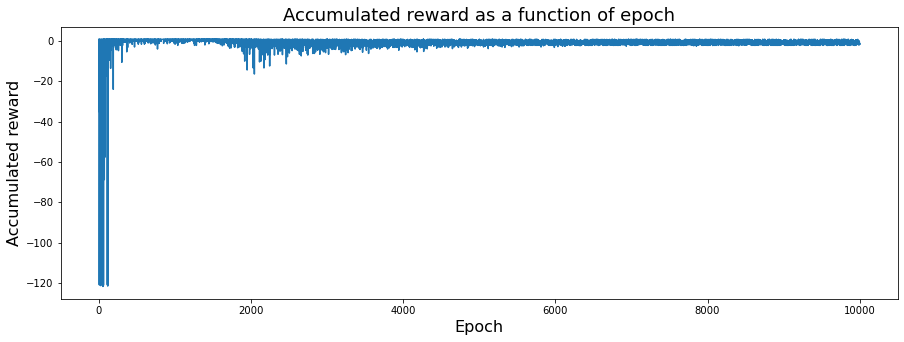

In [18]:
r_list = torch.load("r_list_%s.torch" % taskname)

fig = plt.figure(figsize=(15,5))
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accumulated reward', fontsize=16)
plt.title('Accumulated reward as a function of epoch', fontsize=18)
plt.plot(range(len(r_list)), r_list)
print(len(r_list))


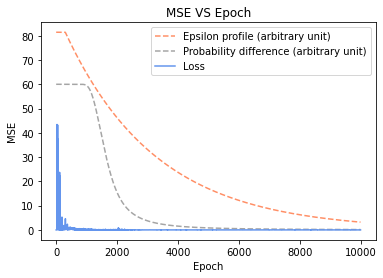

In [19]:
loss_log = torch.load("loss_log_%s.torch" % taskname)

plt.plot(epsilon*90, alpha = 0.6, ls = '--', label = 'Epsilon profile (arbitrary unit)', color = 'orangered')
plt.plot((np.array(mpm)-np.array(mp))*120, alpha = 0.6, ls = '--',
         label = 'Probability difference (arbitrary unit)', color = 'dimgray')
plt.plot(loss_log, label = 'Loss', color = 'cornflowerblue')

plt.title('MSE VS Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

**Show the maze solution and the policy learnt.**

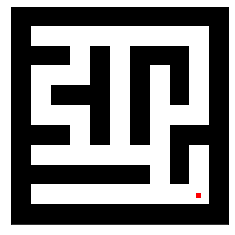

In [35]:
net.load_state_dict(torch.load("net_%s.torch" % taskname))

net.eval()
agent.isgameon = True
agent.use_softmax = False
_ = agent.env.reset(0)
while agent.isgameon:
    agent.make_a_move(net, 0)
    agent.env.draw('')
    clear_output(wait = True)

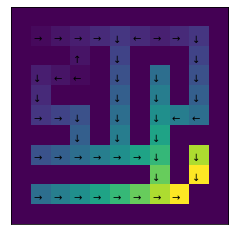

In [21]:
agent.plot_policy_map(net, [0.35,-0.3])

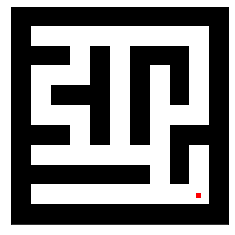

In [22]:
best_net = copy.deepcopy(net)
best_net.load_state_dict(torch.load("best_%s.torch" % taskname))

agent.isgameon = True
agent.use_softmax = False
_ = agent.env.reset(0)
while agent.isgameon:
    agent.make_a_move(best_net, 0)
    agent.env.draw('')
    clear_output(wait = True)

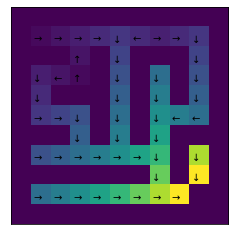

In [23]:
agent.plot_policy_map(best_net, [0.35,-0.3])

## Task 1
**Run the training with 5 different seeds and visualize the average episode reward and the variance within the error bar (with the fill_between function) similar to the Part 1 Q-Learning-final-Project**

Text(0.5, 0, 'Episodes')

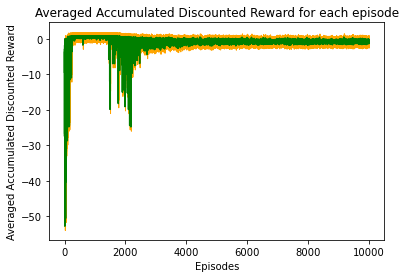

In [24]:
alpha = 1e-6
learning_rate = 1e-4
gamma = 0.9
exploration_rate = -1

numberOfSeeds=5
a_rewards = []

for i in range(numberOfSeeds):

    Transition = collections.namedtuple('Experience', field_names=['state', 'action', 'next_state', 'reward', 'is_game_on'])
    memory_buffer = ExperienceReplay(buffer_capacity)

    agent = Agent(maze = maze_env, memory_buffer = memory_buffer, use_softmax = True)

    net = fc_nn(maze.size, maze.size, maze.size, 4)
    target = fc_nn(maze.size, maze.size, maze.size, 4)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    net.to(device)

    taskname = "task1_seed%s" % i
    
    if RUN_TASK1 == True:
        train(agent, net, target, optimizer, taskname, gamma, exploration_rate)
        torch.save(net.state_dict(), "net_%s.torch" % taskname)
    
    r_list1 = torch.load("r_list_%s.torch" % taskname)
    a_rewards.append(r_list1)

a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)

a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode")
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

## Task 2

**Run "q_learning" and plot the accumulated reward as a function of epoch for the gamma values in (0.8, 0.2)**

In [25]:
alpha = 1e-6
learning_rate = 1e-4
exploration_rate = -1

for gamma in (0.8,0.2):
    
    Transition = collections.namedtuple('Experience', field_names=['state', 'action', 'next_state', 'reward', 'is_game_on'])
    memory_buffer = ExperienceReplay(buffer_capacity)

    agent = Agent(maze = maze_env, memory_buffer = memory_buffer, use_softmax = True)

    net = fc_nn(maze.size, maze.size, maze.size, 4)
    target = fc_nn(maze.size, maze.size, maze.size, 4)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    net.to(device)

    taskname = "task2_gamma%s" % gamma
    
    if RUN_TASK2 == True:
        train(agent, net, target, optimizer, taskname, gamma, exploration_rate)
        torch.save(net.state_dict(), "net_%s.torch" % taskname)
    


Epoch 9999 (number of moves 43)
Game won
[####################################################################################################]
	 Average loss: 0.00004
	 Best average loss of the last 50 epochs: 0.00011, achieved at epoch 9976


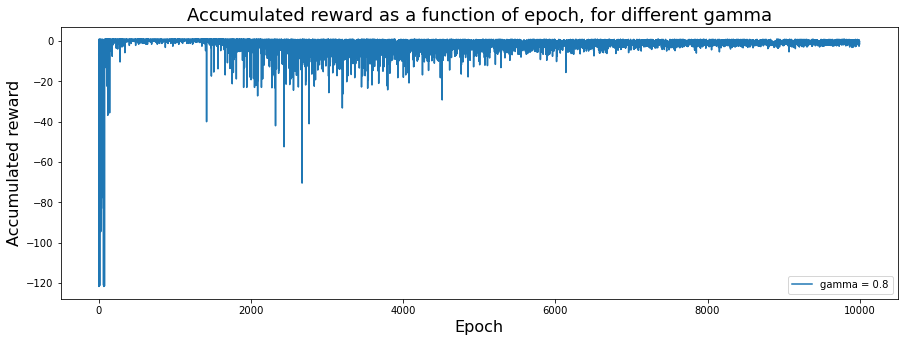

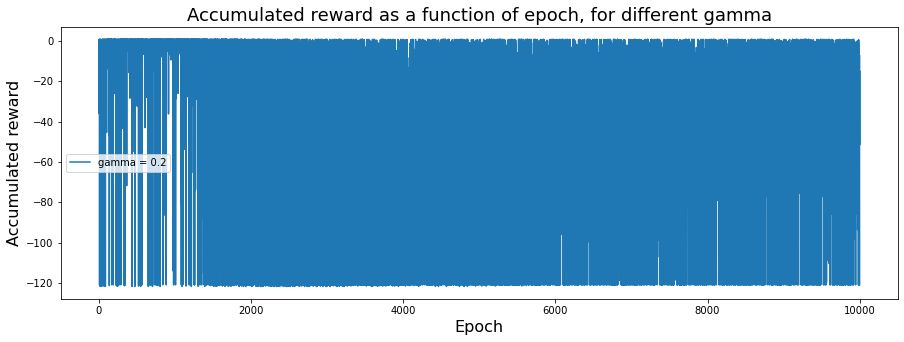

In [26]:
for gamma  in (0.8,0.2):
    fig = plt.figure(figsize=(15,5))
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accumulated reward', fontsize=16)
    plt.title('Accumulated reward as a function of epoch, for different gamma', fontsize=18)

    taskname = "task2_gamma%s" % gamma
    r_list1 = torch.load("r_list_%s.torch" % taskname)
    plt.plot(range(len(r_list1)), r_list1, label = 'gamma = {}'.format(gamma))
    plt.legend()

## Task 3

**Run the q_learning function with adding noise to Q learning function**

## Task 4

**Run "q_learning" and plot the accumulated reward as a function of epoch for the learning rate values in (0, 0.5, 1)**

In [28]:
alpha = 1e-6
gamma = 0.9
exploration_rate = -1

for learning_rate in (1e-6, 1e-4, 1e-2,):

    Transition = collections.namedtuple('Experience', field_names=['state', 'action', 'next_state', 'reward', 'is_game_on'])
    memory_buffer = ExperienceReplay(buffer_capacity)

    agent = Agent(maze = maze_env, memory_buffer = memory_buffer, use_softmax = True)

    net = fc_nn(maze.size, maze.size, maze.size, 4)
    target = fc_nn(maze.size, maze.size, maze.size, 4)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    net.to(device)

    taskname = "task4_lr%s" % learning_rate
    
    if RUN_TASK4 == True:
        train(agent, net, target, optimizer, taskname, gamma, exploration_rate)
        torch.save(net.state_dict(), "net_%s.torch" % taskname)
    
    

Epoch 9999 (number of moves 18)
Game won
[####################################################################################################]
	 Average loss: 2.86472
	 Best average loss of the last 50 epochs: 16.26479, achieved at epoch 2148


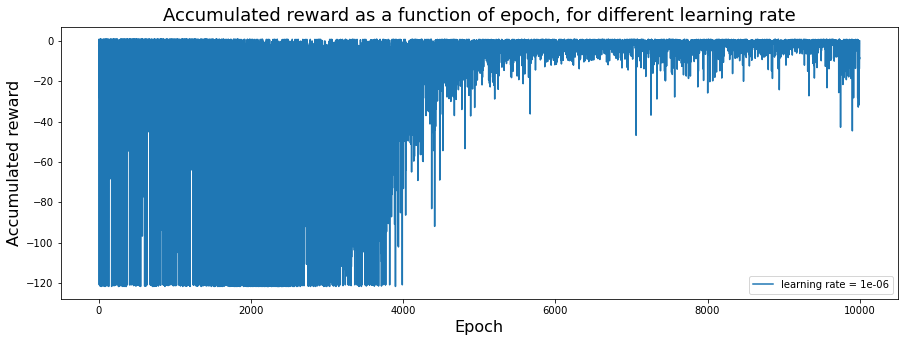

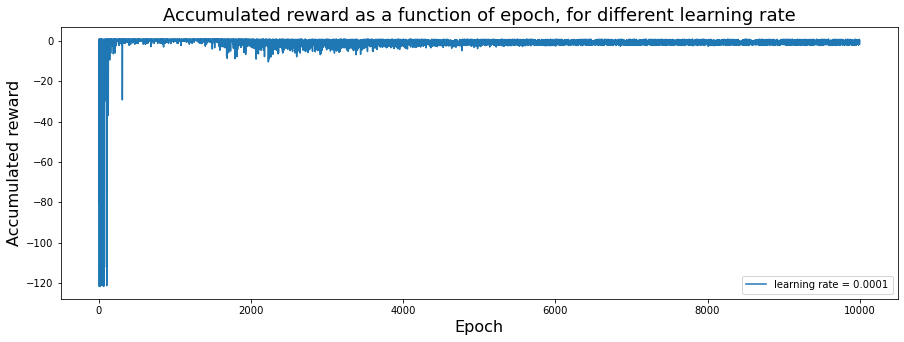

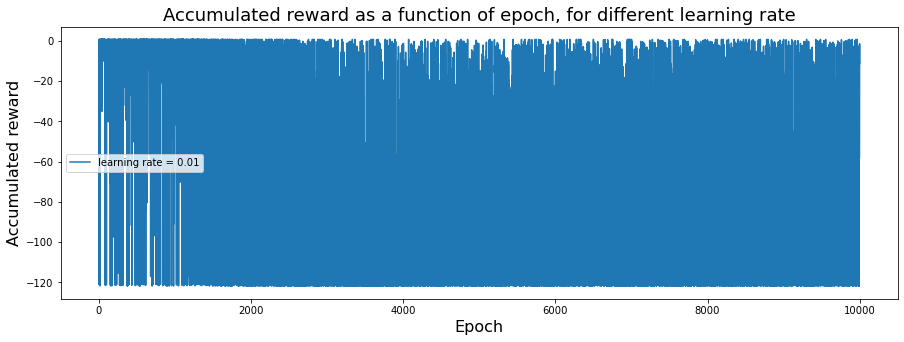

In [29]:
for learning_rate in (1e-6, 1e-4, 1e-2,):

    fig = plt.figure(figsize=(15,5))
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accumulated reward', fontsize=16)
    plt.title('Accumulated reward as a function of epoch, for different learning rate', fontsize=18)

    taskname = "task4_lr%s" % learning_rate
    r_list1 = torch.load("r_list_%s.torch" % taskname)
    plt.plot(range(len(r_list1)), r_list1, label = 'learning rate = {}'.format(learning_rate))
    plt.legend()

## Task 5

**Run "q_learning" and plot the accumulated reward as a function of epoch for the epsilon in (0, 0.5, 1)**

In [30]:
alpha = 1e-6
gamma = 0.9
learning_rate = 1e-4

for exploration_rate in (0.99, 0.5, 0.01):
    
    Transition = collections.namedtuple('Experience', field_names=['state', 'action', 'next_state', 'reward', 'is_game_on'])
    memory_buffer = ExperienceReplay(buffer_capacity)

    agent = Agent(maze = maze_env, memory_buffer = memory_buffer, use_softmax = True)

    net = fc_nn(maze.size, maze.size, maze.size, 4)
    target = fc_nn(maze.size, maze.size, maze.size, 4)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    net.to(device)

    taskname = "task5_epsilon%s" % exploration_rate
    
    if RUN_TASK5 == True:
        train(agent, net, target, optimizer, taskname, gamma, exploration_rate)
        torch.save(net.state_dict(), "net_%s.torch" % taskname)
    
    

Epoch 9999 (number of moves 9)
Game won
[####################################################################################################]
	 Average loss: 0.01305
	 Best average loss of the last 50 epochs: 0.00000, achieved at epoch 8830


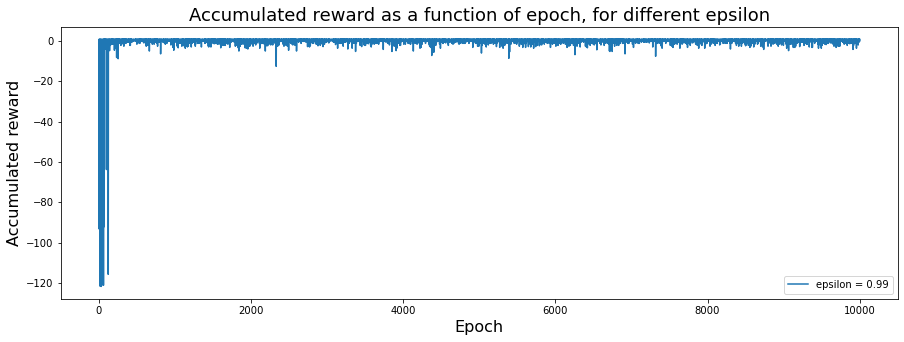

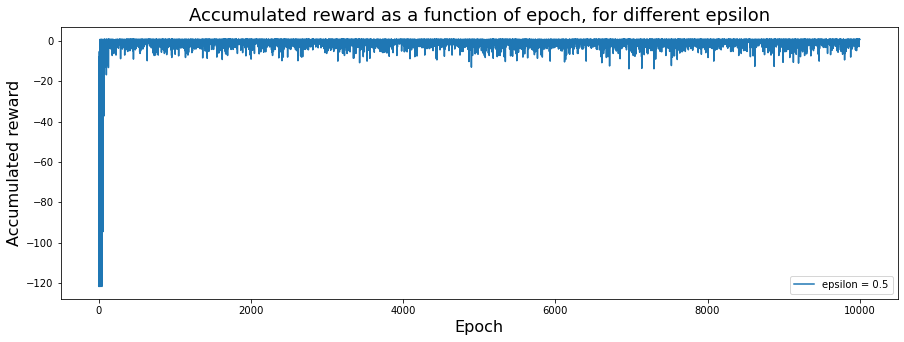

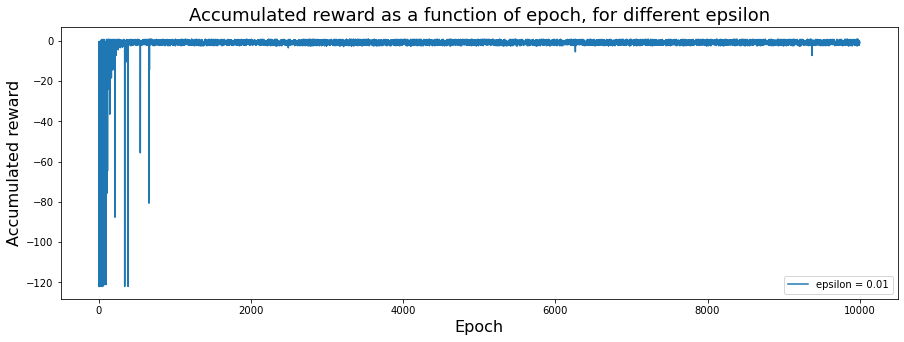

In [37]:
for exploration_rate in (0.99, 0.5, 0.01):

    fig = plt.figure(figsize=(15,5))
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accumulated reward', fontsize=16)
    plt.title('Accumulated reward as a function of epoch, for different epsilon', fontsize=18)

    taskname = "task5_epsilon%s" % exploration_rate
    r_list1 = torch.load("r_list_%s.torch" % taskname)
    plt.plot(range(len(r_list1)), r_list1, label = 'epsilon = {}'.format(exploration_rate))
    plt.legend()

## Task 6

**Run "q_learning" and plot the accumulated reward as a function of epoch for the alpha values in (0.8, 0.09)**

In [32]:
gamma = 0.9
learning_rate = 1e-4
exploration_rate = -1

for noise in (0.8,0.09):

    alpha = noise

    Transition = collections.namedtuple('Experience', field_names=['state', 'action', 'next_state', 'reward', 'is_game_on'])
    memory_buffer = ExperienceReplay(buffer_capacity)

    agent = Agent(maze = maze_env, memory_buffer = memory_buffer, use_softmax = True)

    net = fc_nn(maze.size, maze.size, maze.size, 4)
    target = fc_nn(maze.size, maze.size, maze.size, 4)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    net.to(device)

    taskname = "task6_alpha%s" % alpha
    
    if RUN_TASK6 == True:
        train(agent, net, target, optimizer, taskname, gamma, exploration_rate)
        torch.save(net.state_dict(), "net_%s.torch" % taskname)
    
    

Epoch 9999 (number of moves 3)
Game won
[####################################################################################################]
	 Average loss: 0.00024
	 Best average loss of the last 50 epochs: 0.00000, achieved at epoch 7774


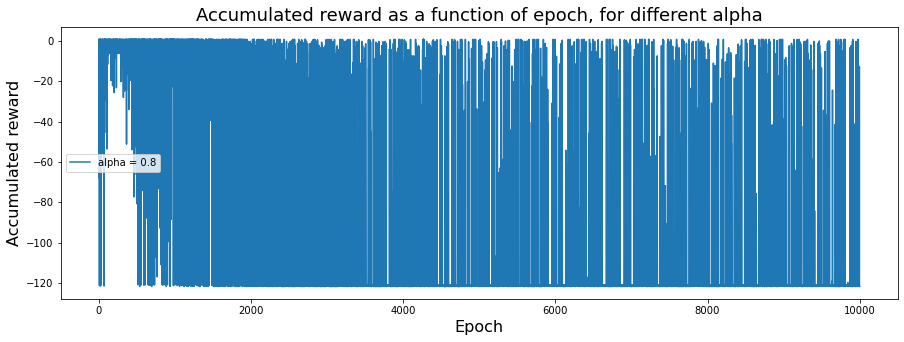

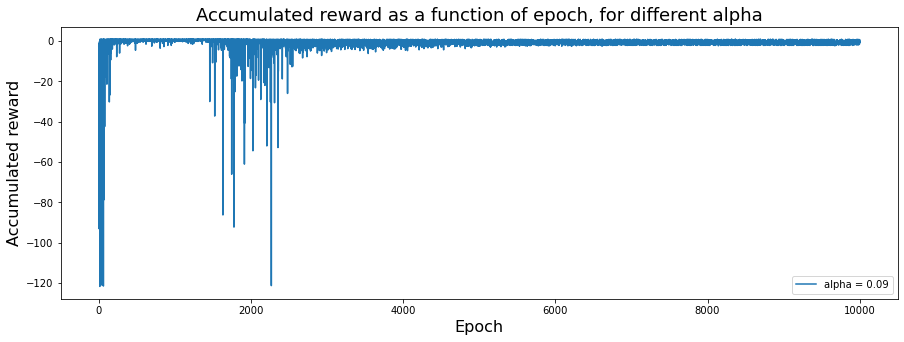

In [33]:
for noise in (0.8,0.09):

    fig = plt.figure(figsize=(15,5))
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accumulated reward', fontsize=16)
    plt.title('Accumulated reward as a function of epoch, for different alpha', fontsize=18)

    taskname = "task6_alpha%s" % noise
    r_list1 = torch.load("r_list_%s.torch" % taskname)
    plt.plot(range(len(r_list1)), r_list1, label = 'alpha = {}'.format(noise))
    plt.legend()


**Observations**

- Explain briefly how the results change for different values of 'gamma'

<font color='blue'>
It is seen that the network cannot be trained with very small gamma; because it cannot plan the future well.
</font>   

- Explain briefly how the results change for different values of 'learning rate'

<font color='blue'>
When the learning rate is very small, training progresses very slowly as the weigths in the network change very little in each update. Therefore, we see that the network cannot be trained in given number of epochs, with low learning rate.
When the learning rate is too high, it causes divergent behavior in the loss function. Therefore, we see that the network cannot be trained with high learning rate, either. 
</font>  

- Explain briefly how the results change for different values of 'alpha'

<font color='blue'>
It is seen that when the noise (alpha) is too high, the agent cannot be trained; because it almost always takes the action it did not intend to, and therefore cannot increase the accumulated reward.
</font> 

- Explain briefly how the results change for different values of 'epsilon'

<font color='blue'>
It is seen that when epsilon is low, it takes the network more time to train. This makes sense because when the epsilon is low, the agent almost always takes the action that gives the max Q at the time, and it may miss some other states with even higher Q value.
</font> 

**Insights**

- Explain the meaning of alpha and gamma

<font color='blue'>
Alpha is the transition noise. Because of the stochastic features (such as wind) of the system, with probability (1-alpha), the agent takes a different action than the intended action.
Gamma is the discount factor. It determines how far in the future to plan. In other words, it chooses between miyopic behaviour and planning. 
</font> 

- Explain briefly the 'Exploration vs. Exploitation Trade-off'

<font color='blue'>
Exploration means exploring the environment to find out information about it. Exploitation means exploiting the information that is already known about the environment, in order to maximize the return. If the agent does exploitation, it will choose the action which gives the maximum Q for the current state. If the agent does exploration, however, it will choose a random action. The problem with exploration is that it may or may not end up with a better return. 
</font> 

- Explain briefly the diference between 'on-policy' and 'off-policy' algorithms

<font color='blue'>
Q-learning is off-policy because it estimates the return (expected accumulated future reward) assuming a greedy policy were followed, despite the fact that it is not following a greedy policy. SARSA is on-policy because it estimates the return assuming that the current policy continues to be followed.
The distinction between Q-learning and SARSA disappears if the current policy is a greedy policy. However, such a strategy would not be good; because the agent would not be exploring its environment.
</font> 

- Explain briefly the meaining of 'Experience Replay'

<font color='blue'>
Experience replay is a replay memory technique used in reinforcement learning, where the agent's experience is stored at each time step, as : $$ e_t = (s_t, a_t, r_t, s_{t+1}) $$
in a data set called the replay memory : $$ D = e_1, e_2, ..., e_N $$
Then we use random samples from this dataset to train the network. The purpose is to obtain a sample of uncorrelated data; because there is a high correlation between actions and states.
</font> 

- Explain briefly the purpose of a target network in DQN algorithm

<font color='blue'>
The objective of the DQN algoritm is to approximate the Q value to the target value (i.e. minimize the loss) :
    $$ Q_{θ}(s,a) -> \text{  }   <- Q^{*}(s,a) $$
where the target value is :
    $$ r + gamma \times max_{a'} {Q_{θ}(s',a')} $$
   
$$  \text{The } Q_{θ}(s,a) \text{ value is obtained by inputting s to the network.} $$
$$  \text{The } Q_{θ}(s',a') \text{ value is obtained by inputting s' to the network.} $$
If both values were optained using the same network with same weights, then the target value would also be moving in the same direction,  :    
    $$ Q_{θ}(s,a) --> \text{  }   <- Q^{*}(s,a)--> $$
So to speak, the optimization would be chasing its own tail. To prevent that, we use a "target network", which is a copy of the actual network, and use it to update the target value. We update the weights of the target network every once in a while.
</font> 

- Explain briefly the difference between epochs and episode

<font color='blue'>
An episode is a sequence of state, action and rewards, that end at the goal state.
An epoch is one forward and one bacward pass of all the training samples, in neural network terminology.
</font> 


**Submission Requirements**
- The submission for this part should contain a executed .ipynb file, pdf of the executed .ipynb file and the maze file which been used for your execution.

**Plotting Requirements**
- please check that all the plots titles, axes labels, legends are in large/readable fonts.



